# Experiment 1.4: smooth parameter transitions

In [Experiment 1.3](ex-1.3-color-mlp-curriculum.ipynb), we used curriculum learning with discrete phases to guide the model towards a structured latent space. While successful, the transitions between phases were abrupt, and the final structure was sensitive to the initial conditions.

This notebook explores a technique to address this: Instead of sudden jumps in hyperparameters between phases, we want to change them gradually over a defined period. Abrupt changes may destabilize training, causing loss spikes and potentially disrupting the learned representations. Smooth transitions could lead to more stable training and potentially allow for simpler, more robust curriculum definitions.

We'll implement this using **minimum jerk trajectories**, a concept borrowed from robotics. This method provides smooth paths between values, minimizing the rate of change of acceleration (jerk).

**Minimum jerk:**
- Ensures continuity up to the third derivative (position, velocity, acceleration, jerk).
- Mimics natural, efficient movements.
- Avoids sharp changes that could shock the optimizer.
- Allows precise control over the transition duration.
- Can incorporate the current "momentum" (velocity and acceleration) of a parameter when starting a new transition.

The minimum jerk trajectory function uses a 5th-degree polynomial to define the path between a start state (position, velocity, acceleration) and an end state over a time interval.

In [1]:
import numpy as np


class MinimumJerkTimingFunction:
    """
    Implements a minimum jerk trajectory for smooth interpolation with guaranteed arrival time.

    Given a starting value at rest (zero velocity and acceleration), this function resembles the ease (cubic spline) timing function in CSS.

    This function also smoothly handles cases where the initial conditions are not at rest, allowing for more dynamic trajectories.
    """

    def __init__(
        self,
        initial_value: float = 0.0,
        initial_velocity: float = 0.0,
        initial_acceleration: float = 0.0,
        final_value: float | None = None,
    ):
        """
        Initialize the interpolator with starting conditions.

        Args:
            initial_value: Starting value
            initial_velocity: Starting velocity (rate of change)
            initial_acceleration: Starting acceleration (optional, default 0)
            final_value: Target final value (optional, default None)
        """
        self.initial_value = initial_value
        self.initial_velocity = initial_velocity
        self.initial_acceleration = initial_acceleration

        self.final_value = final_value if final_value is not None else initial_value
        self.coeffs = self._calculate_coefficients(
            y0=self.initial_value,
            v0=self.initial_velocity,
            a0=self.initial_acceleration,
            y1=self.final_value,
            v1=0.0,  # Target velocity (typically zero)
            a1=0.0,  # Target acceleration (typically zero)
            T=1.0,  # Duration (normalized to 1.0)
        )

    def _calculate_coefficients(self, y0, v0, a0, y1, v1, a1, T):
        """
        Calculate the coefficients for the 5th-degree polynomial.

        Args:
            y0: Initial position
            v0: Initial velocity
            a0: Initial acceleration
            y1: Target position
            v1: Target velocity (typically 0)
            a1: Target acceleration (typically 0)
            T: Duration

        Returns:
            List of 6 coefficients [c0, c1, c2, c3, c4, c5]
        """
        # First 3 coefficients are determined by initial conditions
        c0 = y0
        c1 = v0
        c2 = a0 / 2.0

        # Set up the system of equations for the remaining coefficients
        T2 = T * T
        T3 = T2 * T
        T4 = T3 * T
        T5 = T4 * T

        # Right-hand side of the equation
        b1 = y1 - y0 - v0 * T - (a0 / 2.0) * T2
        b2 = v1 - v0 - a0 * T
        b3 = a1 - a0

        # Coefficient matrix
        A = np.array(
            [
                [T3, T4, T5],
                [3 * T2, 4 * T3, 5 * T4],
                [6 * T, 12 * T2, 20 * T3],
            ],
        )

        b = np.array([b1, b2, b3])

        # Solve the system of equations
        x = np.linalg.solve(A, b)

        # Extract the coefficients
        c3, c4, c5 = x

        return [c0, c1, c2, c3, c4, c5]

    def __call__(self, frac: float):
        """
        Get the interpolated value at a specific time without changing internal state.

        Args:
            frac: Fraction of the total duration to evaluate (0 to 1)

        Returns:
            The value at time t
        """
        # Clamp to duration
        if frac >= 1.0:
            return self.final_value

        # Calculate using the polynomial
        c0, c1, c2, c3, c4, c5 = self.coeffs
        return c0 + c1 * frac + c2 * frac**2 + c3 * frac**3 + c4 * frac**4 + c5 * frac**5

    def get_state(self, frac: float = 0.0):
        c0, c1, c2, c3, c4, c5 = self.coeffs
        value = c0 + c1 * frac + c2 * frac**2 + c3 * frac**3 + c4 * frac**4 + c5 * frac**5

        # Calculate velocity (first derivative)
        velocity = c1 + 2 * c2 * frac + 3 * c3 * frac**2 + 4 * c4 * frac**3 + 5 * c5 * frac**4

        # Calculate acceleration (second derivative)
        acceleration = 2 * c2 + 6 * c3 * frac + 12 * c4 * frac**2 + 20 * c5 * frac**3

        return value, velocity, acceleration

### Visualizing trajectories

Let's visualize how this works. We'll plot the position, velocity, and acceleration for several scenarios where a parameter starts with different initial values and velocities, but all need to smoothly arrive at the same target value (1.0) at the target time (100 steps) with zero velocity and acceleration.

<Figure size 1200x800 with 0 Axes>

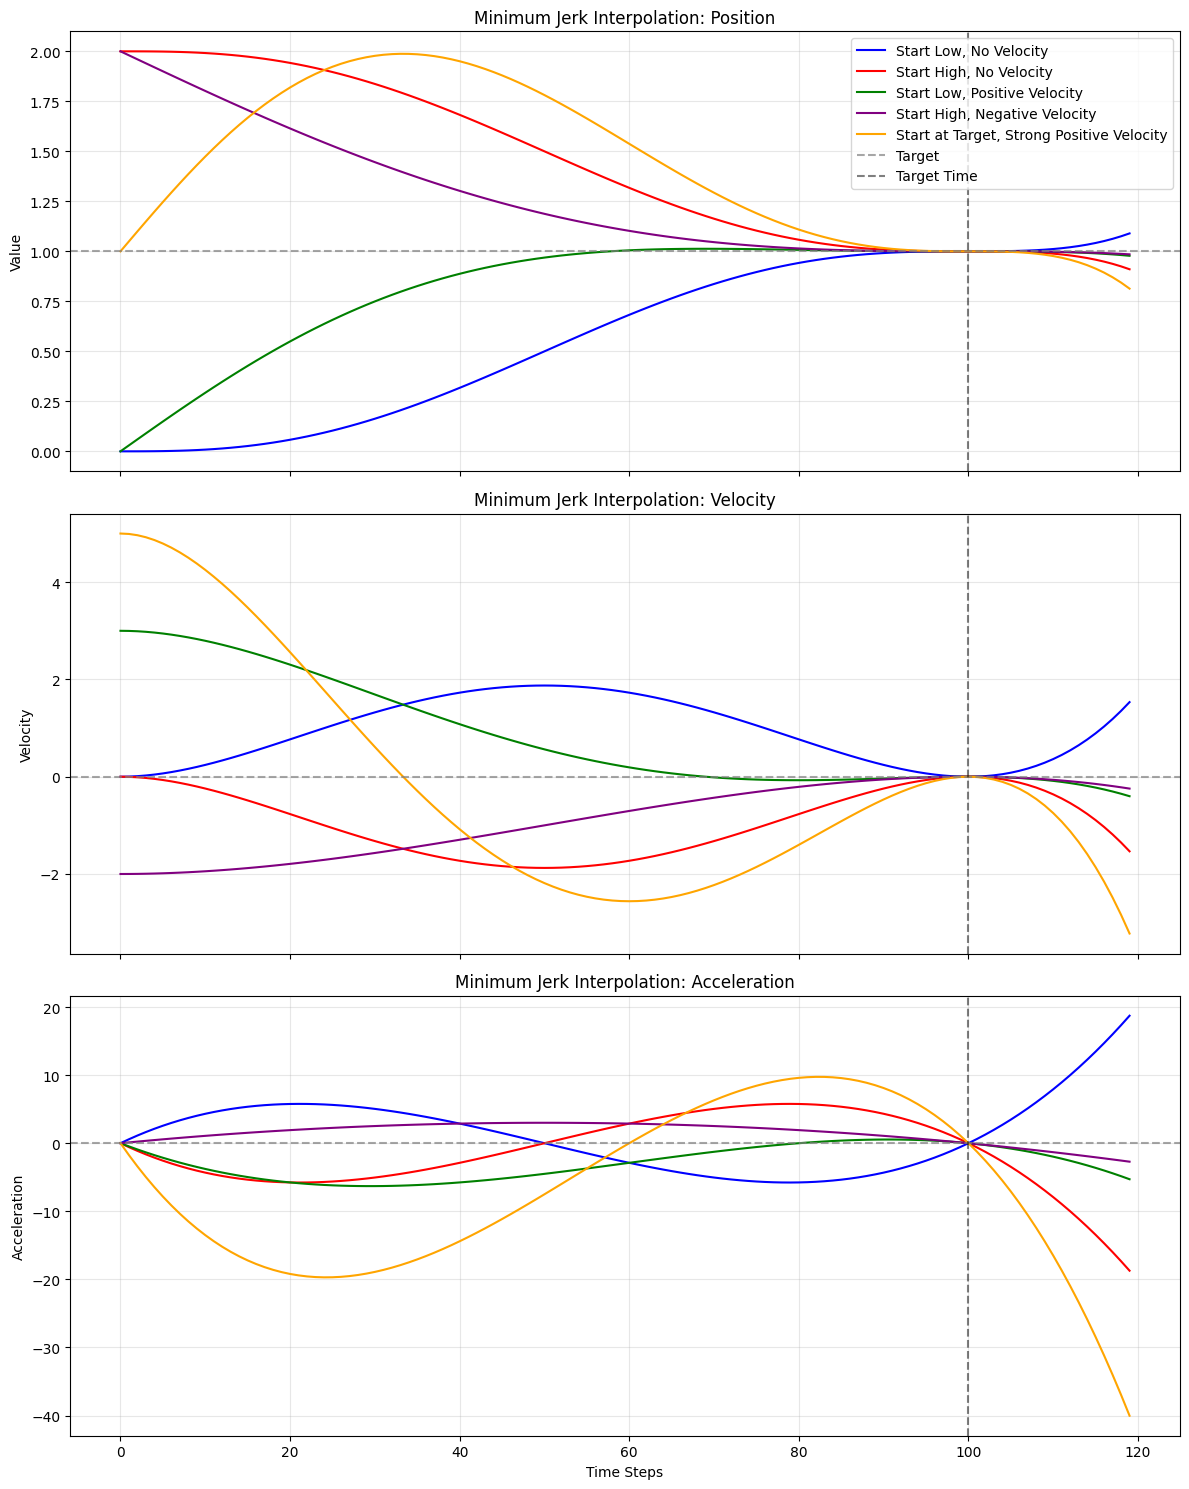

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Create a visualization of different interpolators converging
# Set up the plot
plt.figure(figsize=(12, 8))

# Define common parameters
final_value = 1.0  # All will converge to this value
duration = 100  # Steps to reach target

# Create interpolators with different initial conditions
interpolators = [
    {
        'name': 'Start Low, No Velocity',
        'interp': MinimumJerkTimingFunction(initial_value=0.0, initial_velocity=0.0, final_value=final_value),
        'color': 'blue',
        'linestyle': '-',
    },
    {
        'name': 'Start High, No Velocity',
        'interp': MinimumJerkTimingFunction(initial_value=2.0, initial_velocity=0.0, final_value=final_value),
        'color': 'red',
        'linestyle': '-',
    },
    {
        'name': 'Start Low, Positive Velocity',
        'interp': MinimumJerkTimingFunction(initial_value=0.0, initial_velocity=3.0, final_value=final_value),
        'color': 'green',
        'linestyle': '-',
    },
    {
        'name': 'Start High, Negative Velocity',
        'interp': MinimumJerkTimingFunction(initial_value=2.0, initial_velocity=-2.0, final_value=final_value),
        'color': 'purple',
        'linestyle': '-',
    },
    {
        'name': 'Start at Target, Strong Positive Velocity',
        'interp': MinimumJerkTimingFunction(initial_value=1.0, initial_velocity=5.0, final_value=final_value),
        'color': 'orange',
        'linestyle': '-',
    },
]

# Generate data for each interpolator
time_steps = np.arange(0, duration + 20)  # Add some extra steps to show stabilization
histories = {}

for interp_info in interpolators:
    name = interp_info['name']
    interp = interp_info['interp']

    # Record position, velocity, and acceleration
    positions = []
    velocities = []
    accelerations = []

    for t in time_steps:
        value, velocity, acceleration = interp.get_state(frac=t / duration)
        positions.append(value)
        velocities.append(velocity)
        accelerations.append(acceleration)

    histories[name] = {
        'positions': positions,
        'velocities': velocities,
        'accelerations': accelerations,
        'color': interp_info['color'],
        'linestyle': interp_info['linestyle'],
    }

# Create a three-panel plot: position, velocity, acceleration
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Plot position
for name, history in histories.items():
    ax1.plot(time_steps, history['positions'], color=history['color'], linestyle=history['linestyle'], label=name)

ax1.axhline(y=final_value, color='gray', linestyle='--', alpha=0.7, label='Target')
ax1.axvline(x=duration, color='black', linestyle='--', alpha=0.5, label='Target Time')
ax1.set_ylabel('Value')
ax1.set_title('Minimum Jerk Interpolation: Position')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')

# Plot velocity
for name, history in histories.items():
    ax2.plot(time_steps, history['velocities'], color=history['color'], linestyle=history['linestyle'], label=name)

ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax2.axvline(x=duration, color='black', linestyle='--', alpha=0.5)
ax2.set_ylabel('Velocity')
ax2.set_title('Minimum Jerk Interpolation: Velocity')
ax2.grid(True, alpha=0.3)

# Plot acceleration
for name, history in histories.items():
    ax3.plot(time_steps, history['accelerations'], color=history['color'], linestyle=history['linestyle'], label=name)

ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax3.axvline(x=duration, color='black', linestyle='--', alpha=0.5)
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('Acceleration')
ax3.set_title('Minimum Jerk Interpolation: Acceleration')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The plots demonstrate smooth convergence. Notice how:
- All trajectories reach the target value (1.0) exactly at the target time (100 steps).
- Velocity and acceleration smoothly approach zero by the target time, regardless of the starting conditions.
- Trajectories starting with non-zero velocity may initially overshoot or undershoot before smoothly correcting towards the target.

## The `SmoothProp` Class

Now, let's wrap the timing function in a class to manage a parameter's value and handle transitions automatically.

When you set a new target `value` for a `SmoothProp` instance, it:
1. Captures the *current* state (value, velocity, acceleration) of the ongoing transition (if any).
2. Creates a *new* `MinimumJerkTimingFunction` starting from that captured state and targeting the new value.
3. Resets the internal timer for the new transition.

When you access `.value`, it evaluates the current timing function based on the elapsed time since the last target change.

This allows for changing targets mid-transition while maintaining smoothness.

In [3]:
class SmoothProp:
    timing_function: MinimumJerkTimingFunction | None

    def __init__(self, value: float, transition_duration: float = 0.0):
        self.transition_duration = transition_duration
        self._value = value
        self.timing_function = None
        self.ctime = 0.0

    def step(self, n=1.0):
        self.ctime += n

    @property
    def frac(self):
        return min(max(self.ctime / self.transition_duration, 0.0), 1.0)

    @property
    def value(self):
        """Get the smoothed value, according to the timing function"""
        if self.frac >= 1.0:
            self.timing_function = None
        if not self.timing_function:
            return self._value
        return self.timing_function(self.frac)

    @value.setter
    def value(self, new_value: float):
        """Set the target value"""
        if new_value != self._value and self.transition_duration > 0:
            if self.timing_function is None:
                value, velocity, acceleration = self._value, 0.0, 0.0
            else:
                value, velocity, acceleration = self.timing_function.get_state(self.frac)
            self.timing_function = MinimumJerkTimingFunction(
                initial_value=value,
                initial_velocity=velocity,
                initial_acceleration=acceleration,
                final_value=new_value,
            )
        self.ctime = 0.0
        self._value = new_value

### Simulating curriculum changes

Let's simulate a scenario similar to curriculum learning where the target value of a parameter changes multiple times. We'll use `SmoothProp` to manage the parameter and plot its actual value against the target value over time. We expect the actual value to smoothly track the changing targets.

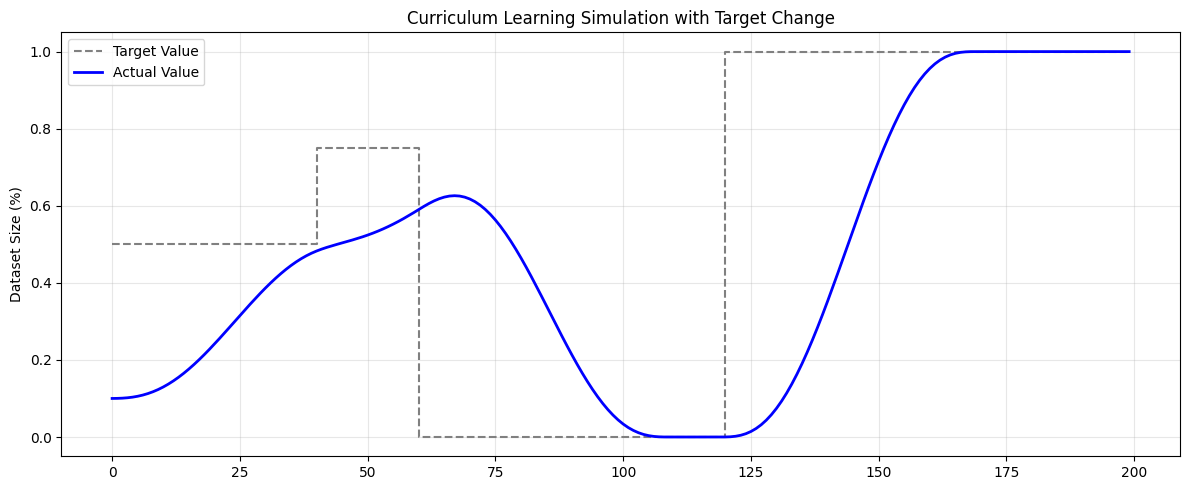

In [ ]:
# Create a second plot focusing on a specific use case: curriculum learning with mid-trajectory target changes

# Create interpolator for curriculum learning simulation
param = SmoothProp(value=0.1)
param.transition_duration = 50
param.value = 0.5

positions = []
velocities = []
time_steps = np.arange(0, 200)

events = {
    0: 0.5,
    40: 0.75,
    60: 0.0,
    120: 1.0,
}
targets = []


# Simulate curriculum with a target change midway
for t in time_steps:
    t = int(t)
    if t in events:
        target = events[t]
        param.value = target

    param.step()
    positions.append(param.value)
    targets.append(param._value)
    # velocities.append(curriculum.velocity)

# Plot curriculum progression
fig, ax1 = plt.subplots(figsize=(12, 5), sharex=True)

# Plot target values as a step function
ax1.step(time_steps, targets, color='gray', linestyle='--', linewidth=1.5, where='post', label='Target Value')

# Add a more descriptive label for the actual values
ax1.plot(time_steps, positions, color='blue', linewidth=2, label='Actual Value')

# Add legend
ax1.legend(loc='best')

ax1.set_ylabel('Dataset Size (%)')
ax1.set_title('Curriculum Learning Simulation with Target Change')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Nice! `SmoothProp` successfully handles changing targets, using smooth transitions that maintain the momentum from the previous trajectory. The actual parameter value gracefully follows the step changes in the target value.

Now we can revisit the color curriculum learning problem from Experiment 1.3. In the next experiment, we will apply these smooth transitions to the curriculum parameters (like the range of hues, saturation, or value in the training data, and regularization weights) to see if we can achieve a stable and well-structured latent space with less manual phase definition and tuning.